In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["JAX_ENABLE_X64"] = "True"

In [18]:
from functools import partial
import jax
import jax.numpy as jnp
import typer
from jax import jit

from bpd import DATA_DIR
from bpd.io import load_dataset
from bpd.pipelines import pipeline_shear_inference_simple


import matplotlib.pyplot as plt 

In [5]:
# fpath_plus = "/pscratch/sd/i/imendoza/data/cache_chains/exp40_42/interim_samples_42_plus.npz"
# fpath_minus = "/pscratch/sd/i/imendoza/data/cache_chains/exp40_42/interim_samples_42_minus.npz"

In [131]:
fpath_plus = "/pscratch/sd/i/imendoza/data/cache_chains/exp41_43/interim_samples_43_plus.npz"
fpath_minus = "/pscratch/sd/i/imendoza/data/cache_chains/exp41_43/interim_samples_43_minus.npz"

In [132]:
samples_plus = load_dataset(fpath_plus)
samples_minus = load_dataset(fpath_minus)

In [133]:
e_post_plus = samples_plus["e_post"]
e_post_minus = samples_minus["e_post"]
true_g = samples_plus["true_g"]
assert jnp.all(true_g == - samples_minus['true_g'])
sigma_e = samples_plus["sigma_e"]
sigma_e_int = samples_plus["sigma_e_int"]

assert jnp.all(samples_plus["e1_true"] == samples_minus["e1_true"])
assert jnp.all(samples_plus["f"] == samples_minus["f"])

e_post_plus.shape, e_post_minus.shape

((1000, 100, 2), (1000, 100, 2))

In [135]:
seed = 42
rng_key = jax.random.key(seed)

In [136]:
raw_pipeline = partial(
    pipeline_shear_inference_simple,
    sigma_e=sigma_e,
    sigma_e_int=sigma_e_int,
    n_samples=3000,
    initial_step_size=1e-3,
    max_num_doublings=2
)
pipe = jit(raw_pipeline)


In [137]:
# jit
_ = pipe(rng_key, e_post_plus[:2, :, :], true_g)

In [138]:
g_samples_plus = pipe(rng_key, e_post_plus, init_g=jnp.array([0.,0.]))

In [139]:
g_samples_minus = pipe(rng_key, e_post_minus, init_g=jnp.array([0.,0.]))

In [140]:
g_samples_plus.shape, g_samples_minus.shape

((3000, 2), (3000, 2))

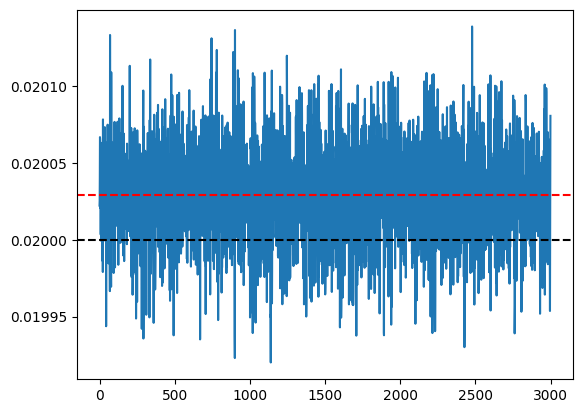

In [141]:
g1p = g_samples_plus[:, 0]

plt.plot(g1p)
plt.axhline(g1p.mean(), color='r', linestyle='--')
plt.axhline(0.02, color='k', linestyle='--')

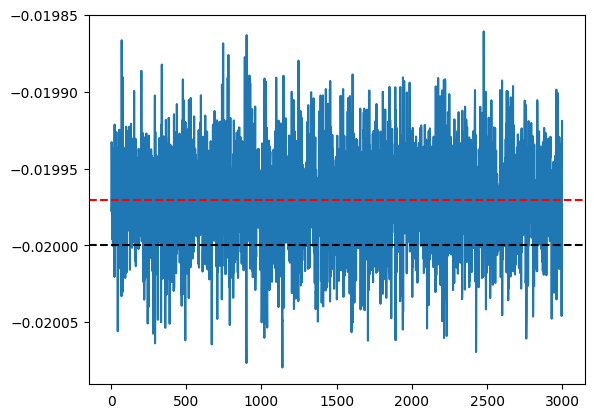

In [142]:
g1m = g_samples_minus[:, 0]

plt.plot(g1m)
plt.axhline(g1m.mean(), color='r', linestyle='--')
plt.axhline(-0.02, color='k', linestyle='--')

In [127]:
abs(g1p.mean().item() - 0.02), abs(g1m.mean().item() + 0.02)

(0.000650109273606328, 0.00021818679297900753)